## Rough volatility with Python

<p>


Jim Gatheral

For Python Quants, New York, Friday May 6, 2016

  
<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/BaruchLogo2.png" align = "left" width=160></h3>  

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/MFElogo.png" align = "right" width=100></h3>

### Acknowledgements

The code in this iPython notebook used to be in R.  I am very grateful to Yves Hilpisch and Michael Schwed for translating my R-code to Python.

For slideshow functionality I use RISE by Damián Avila.


$$
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\bea}{\begin{eqnarray}}
\newcommand{\eea}{\end{eqnarray}}
\newcommand{\ben}{\begin{enumerate}}
\newcommand{\een}{\end{enumerate}}
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\beq}{\begin{equation}}
\newcommand{\eeq}{\end{equation}}
\newcommand{\bv}{\begin{verbatim}}
\newcommand{\ev}{\end{verbatim}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\mP}{\mathbb{P}}
\newcommand{\mQ}{\mathbb{Q}}
\newcommand{\sigl}{\sigma_L}
\newcommand{\BS}{\rm BS}
\newcommand{\vix}{\text{VIX}}
\newcommand{\p}{\partial}
\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\mt}{\mathbf{t}}
\newcommand{\mS}{\mathbf{S}}
\newcommand{\tC}{\widetilde{C}}
\newcommand{\hC}{\widehat{C}}
\newcommand{\cE}{\mathcal{E}}
\newcommand{\tH}{\widetilde{H}}
\newcommand{\cD}{\mathcal{D}}
\newcommand{\cM}{\mathcal{M}}
\newcommand{\cS}{\mathcal{S}}
\newcommand{\cR}{\mathcal{R}}
\newcommand{\cF}{\mathcal{F}}
\newcommand{\cV}{\mathcal{V}}
\newcommand{\cG}{\mathcal{G}}
\newcommand{\cv}{\mathcal{v}}
\newcommand{\cg}{\mathcal{g}}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\cO}{\mathcal{O}}
\newcommand{\dt}{\Delta t}
\newcommand{\tr}{{\rm tr}}
\newcommand{\sgn}{\mathrm{sign}}
\newcommand{\ee}[1]{{\mathbb{E}\left[{#1}\right]}}
\newcommand{\eef}[1]{{\mathbb{E}\left[\left.{#1}\right|\cF_t\right]}}
\newcommand{\eefm}[2]{{\mathbb{E}^{#2}\left[\left.{#1}\right|\cF_t\right]}}
\newcommand{\angl}[1]{{\langle{#1}\rangle}}
$$



### Outline of presentation

* The time series of historical volatility
    - Scaling properties

* The RFSV model

* Pricing under rough volatility

* Forecasting realized variance

* The time series of variance swaps

* Relating historical and implied



### The time series of realized variance

- Assuming an underlying variance process $v_s$, integrated variance $
\frac 1 \delta \,\int_t^{t+\delta}\,v_s\,ds$ may (in principle) be estimated arbitrarily accurately given enough price data.

    - In practice, market microstructure noise makes estimation harder at very high frequency.
    - Sophisticated estimators of integrated variance have been developed to adjust for market microstructure noise.  See Gatheral and Oomen <sup id="cite_ref-GO" class="reference"><a href="#cite_note-GO"><span>[</span>6<span>]</span></a></sup> (for example) for details of these.

- The Oxford-Man Institute of Quantitative Finance makes historical realized variance (RV) estimates freely available at http://realized.oxford-man.ox.ac.uk.  These estimates are updated daily.

    - Each day, for 21 different indices, all trades and quotes are used to estimate realized (or integrated) variance over the trading day from open to close.



- Using daily RV estimates as proxies for instantaneous variance, we may investigate the time series properties of $v_t$ empirically.

First load all necessary Python libraries.

In [12]:
import warnings; warnings.simplefilter('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
#from matplotlib.mlab import stineman_interp
import pandas as pd
#import pandas.io.data as web
from pandas_datareader import data as web
from urllib.request import urlopen
import zipfile as zi 
from io import StringIO 
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
import seaborn as sns; sns.set()
%matplotlib inline

Then update and save the latest Oxford-Man data.

TypeError: initial_value must be str or None, not bytes

There are many different estimates of realized variance, all of them very similar.  We will use the realized kernel estimates denoted by ".rk".

In [16]:
df = pd.read_csv('OxfordManRealizedVolatilityIndices.csv', index_col=0, header=2 )
rv1 = pd.DataFrame(index=df.index)
for col in df.columns:
    if col[-3:] == '.rk':
        rv1[col] = df[col]
#rv1.index = [dt.datetime.strptime(str(date), "%Y%m%d") for date in rv1.index.values]

Let's plot SPX realized variance.

In [17]:
spx = pd.DataFrame(rv1['SPX2.rk'])
spx.plot(color='red', grid=True, title='SPX realized variance',
         figsize=(16, 9), ylim=(0,0.003));

KeyError: 'SPX2.rk'

Figure 1: Oxford-Man KRV estimates of SPX realized variance from January 2000 to the current date.

In [5]:
spx.head()

,SPX2.rk
2000-01-03,0.000161
2000-01-04,0.000264
2000-01-05,0.000305
2000-01-06,0.000149
2000-01-07,0.000123


In [6]:
spx.tail()

,SPX2.rk
2016-04-27,0.000031
2016-04-28,0.000031
2016-04-29,0.000048
2016-05-02,0.000028
2016-05-03,0.000041


We can get SPX data from Yahoo using the `DataReader` function:

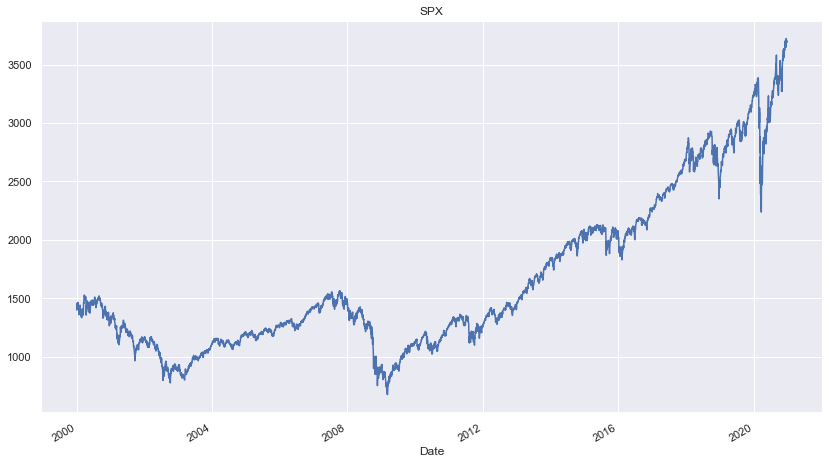

In [18]:
SPX = web.DataReader(name = '^GSPC',data_source = 'yahoo', start='2000-01-01')
SPX = SPX['Adj Close']
SPX.plot(title='SPX',figsize=(14, 8));

### The smoothness of the volatility process


For $q\geq 0$, we define the $q$th sample moment of differences of log-volatility at a given lag $\Delta$.($\angl{\cdot}$ denotes the sample average):

$$
m(q,\Delta)=\angl{\left|\log \sigma_{t+\Delta} -\log \sigma_{t} \right|^q}
$$

For example

$$
m(2,\Delta)=\angl{\left(\log \sigma_{t+\Delta} -\log \sigma_{t} \right)^2}
$$

is just the sample variance of differences in log-volatility at the lag $\Delta$.




### Scaling of $m(q,\Delta)$ with lag $\Delta$

In [19]:
spx['sqrt']= np.sqrt(spx['SPX2.rk'])
spx['log_sqrt'] = np.log(spx['sqrt'])

def del_Raw(q, x): 
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q)
            for lag in x]

NameError: name 'spx' is not defined

[0.072526605081197543, 0.14178030350291049, 0.20760692212873791, 0.27007948205423049, 0.38534332343872962]


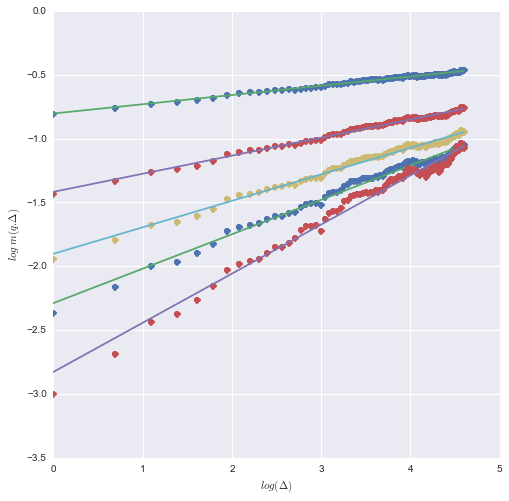

In [9]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o') 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    
print zeta_q

Figure 2: $\log m(q,\Delta)$ as a function of $\log \Delta$, SPX.

### Monofractal scaling result

- From the above log-log plot, we see that for each $q$, $m(q,\Delta) \propto \Delta ^{\zeta_q}$.


- How does $\zeta_q$ scale with $q$?

### Scaling of $\zeta_q$ with $q$

0.131697049909


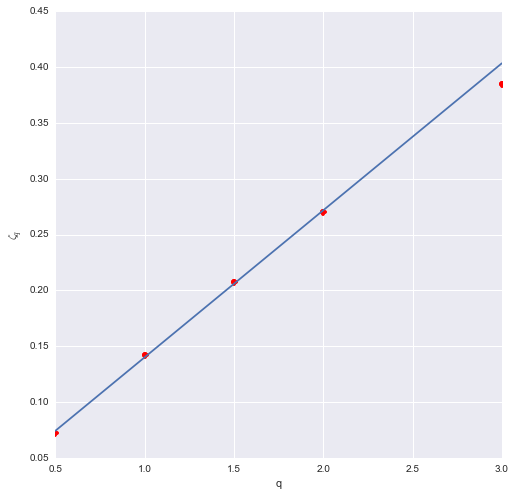

In [10]:
plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)

Figure 3: Scaling of $\zeta_q$ with $q$.

We find the monofractal scaling relationship

$$
\zeta_q = q\,H
$$

with $H \approx 0.13$.

- Note however that $H$ does vary over time, in a narrow range.


- Note also that our estimate of $H$ is biased high because we proxied instantaneous variance $v_t$ with its average over each day $\frac 1T\,\int_0^T\,v_t\,dt$, where $T$ is one trading day.

### Estimated $H$ for all indices

We now repeat this analysis for all 21 indices in the Oxford-Man dataset.

In [11]:
def dlsig2(sic, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
        print a.info()
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

In [12]:
h = list()
nu = list()

for col in rv1.columns:
    sig = rv1[col]
    sig = np.log(np.sqrt(sig))
    sig = sig.dropna()
    model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
    nu.append(np.sqrt(np.exp(model[1])))
    h.append(model[0]/2.)
    
OxfordH = pd.DataFrame({'names':rv1.columns, 'h_est': h, 'nu_est': nu})
  

In [13]:
OxfordH

,h_est,names,nu_est
0,0.133954,SPX2.rk,0.321337
1,0.142315,FTSE2.rk,0.270677
2,0.113366,N2252.rk,0.320396
3,0.150251,GDAXI2.rk,0.274873
4,NaN,RUT2.rk,NaN
5,0.083370,AORD2.rk,0.359025
6,0.131013,DJI2.rk,0.317327
7,NaN,IXIC2.rk,NaN
8,0.130485,FCHI2.rk,0.291967
9,0.103370,HSI2.rk,0.281453


### Distributions of $(\log \sigma_{t+\Delta}-\log \sigma_t)$ for various lags $\Delta$

Having established these beautiful scaling results for the moments, how do the histograms look?

In [14]:
def plotScaling(j, scaleFactor):
    col_name = rv1.columns[j]
    v = rv1[col_name]
    x = np.arange(1,101)
    
    def xDel(x, lag):
        return x-x.shift(lag)
    
    def sdl(lag):
        return (xDel(np.log(v), lag)).std()
    
    sd1 = (xDel(np.log(v), 1)).std()
    h = OxfordH['h_est'][j]
    f, ax = plt.subplots(2,2,sharex=False, sharey=False, figsize=(10, 10))
    
    for i_0 in range(0, 2):
        for i_1 in range(0, 2):
            la = scaleFactor ** (i_1*1+i_0*2)
        
            hist_val = xDel(np.log(v), la).dropna()
            std = hist_val.std()
            mean = hist_val.mean()
        
            ax[i_0][i_1].set_title('Lag = %s Days' %la)
            n, bins, patches = ax[i_0][i_1].hist(hist_val.values, bins=100,
                                   normed=1, facecolor='green',alpha=0.2)
            ax[i_0][i_1].plot(bins, mlab.normpdf(bins,mean,std), "r")
            ax[i_0][i_1].plot(bins, mlab.normpdf(bins,0,sd1 * la ** h), "b--")
            hist_val.plot(kind='density', ax=ax[i_0][i_1])
        
   

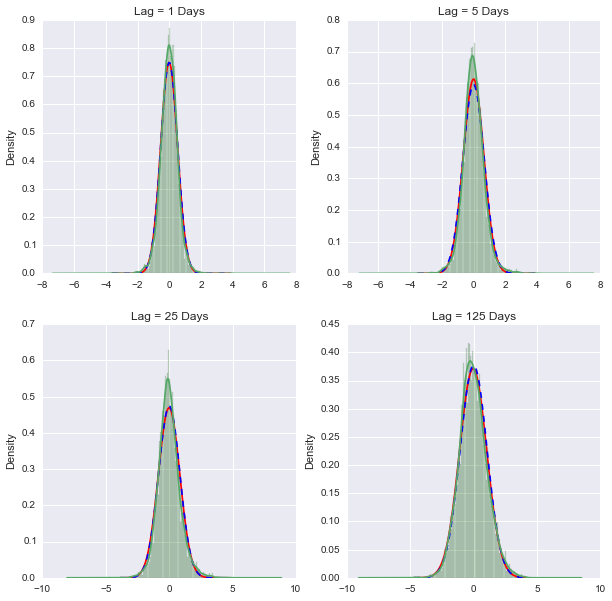

In [15]:
 plotScaling(1,5)

Figure 4: Histograms of $(\log \sigma_{t+\Delta}-\log \sigma_t)$ for various lags $\Delta$; normal fit in red; $\Delta=1$ normal fit scaled by $\Delta^{0.14}$ in blue.


### Universality?

- <span>[Gatheral, Jaisson and Rosenbaum]<sup id="cite_ref-GJR" class="reference"><a href="#cite_note-GJR"><span>[</span>5<span>]</span></a></sup> compute daily realized variance estimates over one hour windows for DAX and Bund futures contracts, finding similar scaling relationships.


- We have also checked that Gold and Crude Oil futures scale similarly.

    - Although the increments $(\log \sigma_{t+\Delta}-\log \sigma_t)$ seem to be fatter tailed than Gaussian.  

### A natural model of realized volatility

- As noted originally by <span>[Andersen et al.]<sup id="cite_ref-ABDE" class="reference"><a href="#cite_note-ABDE"><span>[</span>1<span>]</span></a></sup>, distributions of differences in the log of realized volatility are close to Gaussian.

    - This motivates us to model $\sigma_t$ as a lognormal random variable.


- Moreover, the scaling property of variance of RV differences suggests the model:

<a name="eq:dataDriven"></a>(1)
$$
\log \sigma_{t+\Delta} - \log \sigma_t =\nu\,\left( W^H_{t+\Delta}-W^H_t\right)
$$

where $W^H$ is fractional Brownian motion.

- In  <span>[Gatheral, Jaisson and Rosenbaum]<sup id="cite_ref-GJR" class="reference"><a href="#cite_note-GJR"><span>[</span>5<span>]</span></a></sup>, we refer to a stationary version of [(1)](#eq:dataDriven) as the RFSV (for Rough Fractional Stochastic Volatility) model.

### Fractional Brownian motion (fBm)

- *Fractional Brownian motion* (fBm) $\{W^H_t; t \in \mathbb{R}\}$ is the unique Gaussian process with mean zero and autocovariance function
$$
\ee{ W^H_t\,W^H_s  } = \frac12\,\left\{ |t|^{2\,H}+|s|^{2\,H}-|t-s|^{2\,H}  \right\}
$$
where $H \in (0,1)$ is called the *Hurst index* or parameter.
   - In particular, when $H=1/2$, fBm is just Brownian motion.
 
   - If $H>1/2$, increments are positively correlated.% so the process is trending.
   - If $H<1/2$, increments are negatively correlated.% so the process is reverting.

 

### Representations of fBm

There are infinitely many possible representations of fBm in terms of Brownian motion.  For example, with $\gamma = \frac 12 - H$,


<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
Mandelbrot-Van Ness</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>

$$
W^H_t ={C_H}\,\left\{\int_{-\infty}^t \,\frac{dW_s}{(t-s)^\gamma} - \int_{-\infty}^0 \,\frac{dW_s}{(-s)^\gamma}\right\}.
$$
<br>

</div>

</blockquote>

The choice

$$
C_H = \sqrt{ \frac{2\,H\,\Gamma(3/2-H)}{\Gamma(H+1/2)\,\Gamma(2-2\,H)}}
$$

ensures that

$$
\ee{W^H_t\,W^H_s }= \frac{1}{2}\,\left\{t^{2 H} + s^{2 H} - |t-s|^{2 H}\right\}.
$$

### Does simulated RSFV data look real?

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/02/vol2.png" align = "left" width=900></h3> 

Figure 8: Volatility of SPX (above) and of the RFSV model (below).

### Remarks on the comparison

 
  - The simulated and actual graphs look very alike. 
 
  - Persistent periods of high volatility alternate with low volatility periods. 
  
  - $H \sim 0.1$ generates very rough looking sample paths (compared with $H=1/2$ for Brownian motion).
 
  - Hence *rough volatility*.
  

  - On closer inspection, we observe fractal-type behavior.
 
  - The graph of volatility over a small time period looks like the same graph over a much longer time period.
  
  - This feature of volatility has been investigated both empirically and theoretically in, for example, <span>[Bacry and Muzy]<sup id="cite_ref-BacryMuzy" class="reference"><a href="#cite_note-BacryMuzy"><span>[</span>3<span>]</span></a></sup>
.
 
  - In particular, their Multifractal Random Walk (MRW) is related to a limiting case of the RSFV model as $H \to 0$.
  
 

### Pricing under rough volatility

The foregoing behavior suggest the following model (see <span>[Bayer et al.]<sup id="cite_ref-BayerFriz" class="reference"><a href="#cite_note-BayerFriz"><span>[</span>2<span>]</span></a></sup> for volatility under the real (or historical or physical) measure $\mP$:

$$
 \log \sigma_t =\nu\,W^H_t.
$$

Let $\gamma=\frac{1}{2}-H$.  We choose the Mandelbrot-Van Ness representation of fractional Brownian motion $W^H$ as follows:

$$
W^H_t ={C_H}\,\left\{\int_{-\infty}^t \,\frac{dW^{\mP}_s}{(t-s)^\gamma} - \int_{-\infty}^0 \,\frac{dW^{\mP}_s}{(-s)^\gamma}\right\}.
$$



Then

$$
\begin{eqnarray}
&&\log v_u - \log v_t \nonumber\\
&=&\nu\,C_H\,\left\{ \int_t^u\,\frac{1}{(u-s)^\gamma}\,d{W}^{\mP}_s  +\int_{-\infty}^t\,\left[ \frac{1}{(u-s)^\gamma}-\frac{1}{(t-s)^\gamma} \right]\,d{W}^{\mP}_s\right\}\nonumber\\
&=:& 2\,\nu\,C_H\,\left[M_t(u)+ Z_t(u)\right].
\end{eqnarray}
$$

- Note that $\eefm{M_t(u)}{\mP}=0$ and $Z_t(u)$ is $\cF_t$-measurable.  

  - To price options, it would seem that we would need to know $\cF_t$, the entire history of the Brownian motion $W_s$ for $s<t$!

  

### Pricing under $\mP$


Let

$$
\tilde W^{\mP}_t(u) := \sqrt{2\,H}\,\int_t^u\,\frac{dW^{\mP}_s}{(u-s)^\gamma}
$$

With 
$\eta := 2\,\nu\,C_H/\sqrt{2\,H}$ we have $2\,\nu\,C_H\, M_t(u)
= \eta\, \tilde W^{\mP}_t(u)$ so denoting the stochastic exponential by $\cE(\cdot)$, we may write

$$
\begin{eqnarray}
v_u &=& v_t \exp\left\{  \eta \tilde W^{\mP}_t(u) +
 2\,\nu\,C_H\, 
Z_t(u) \right\}\nonumber\\
&=& \eefm{v_u}{\mP}\,\cE \left(\eta\,\tilde W^{\mP}_t(u) \right).
%\label{eq:rBergomiP}
\end{eqnarray}
$$  
 

  - The conditional distribution of $v_u$ depends on $\cF_t$ only through the variance forecasts $\eefm{v_u}{\mP}$, 
 
 
 - To price options, one does not need to know $\cF_t$, the entire history of the Brownian motion $W_s^{\mP}$ for $s<t$.

 

### Pricing under $\mQ$

Our model under $\mP$ reads:

<a name="eq:Pmodel"></a>(2)
$$
v_u =\eefm{v_u}{\mP}\,\cE\left(\eta\,\tilde W^{\mP}_t(u) \right).
%\label{eq:Pmodel}
$$

Consider some general change of measure

$$
dW^{\mP}_s = dW^{\mQ}_s + \lambda_s\,ds,
%\label{eq:dQdP}
$$

where $\{ \lambda_s: s > t \}$  has a natural interpretation as the price of volatility risk. 

We may then rewrite [(2)](#eq:Pmodel) as

$$
v_u
=  \eefm{v_u}{\mP}\,\cE\left(\eta\,\tilde W^{\mQ}_t(u) \right)
\exp \left\{ \eta\,\sqrt{2\,H}\, \int_t^u\,\frac{\lambda_s}{(u-s)^\gamma}\,ds\right\}.
%\label{eq:explicitBergomiQ1}
$$
 
- Although the conditional distribution of $v_u$ under $\mP$ is lognormal, it will not be lognormal in general under $\mQ$.  
 
  - The upward sloping smile in VIX options means $\lambda_s$ cannot be deterministic in this picture.

### The rough Bergomi (rBergomi) model

Let's nevertheless consider the simplest change of measure 

$$
d{W}^{\mP}_s = d{W}^{\mQ}_s + \lambda(s)\,ds, 
$$

where $\lambda(s)$ is a deterministic function of $s$.  Then from [(2)](#eq:Pmodel), we would have

$$
\begin{eqnarray}
v_u 
&=&  \eefm{v_u}{\mP}\,\cE\left(\eta\,\tilde W^{\mQ}_t(u) \right)
\exp \left\{ \eta\,\sqrt{2\,H}\,  \int_t^u\,\frac{1}{(u-s)^\gamma}\,\lambda(s)\,ds\right\}\nonumber\\
&=& \xi_t(u) \,\cE\left(\eta\,\tilde W^{\mQ}_t(u) \right)%\label{eq:explicitBergomiQ}
\end{eqnarray}
$$

where the forward variances $\xi_t(u) =  \eefm{v_u}{\mQ}$ are (at least in principle) tradable and  observed in the market.

 

-  $\xi_t(u)$ is the product of two terms:
  
      - $ \eefm{v_u}{\mP}$ which depends on the historical path $\{W_s, s<t \}$ of the Brownian motion
      - a term which depends on the price of risk $\lambda(s)$.
  
  

### Features of the rough Bergomi model


 - The rBergomi model is a non-Markovian generalization of the Bergomi model:
$$
\eef{v_u}\neq \E[v_u|v_t].
$$
    - The rBergomi model is Markovian in the (infinite-dimensional) state vector $\eefm{v_u}{\mQ}=\xi_t(u)$.


  - We have achieved our aim from Session 1 of replacing the exponential kernels in the Bergomi model with a power-law kernel.  
 
- We may therefore expect that the rBergomi model will generate a realistic term structure of ATM volatility skew.

### Re-interpretation of the conventional Bergomi model

 
  - A conventional $n$-factor Bergomi model is not self-consistent for an arbitrary choice of the initial forward variance curve $\xi_t(u)$.
 
 - $\xi_t(u)=\eef{v_u}$ should be consistent with the assumed dynamics.
  

  
- Viewed from the perspective of the fractional Bergomi model however:
 
  - The initial curve $\xi_t(u)$ reflects the history $\{W_s; s<t\}$ of the driving Brownian motion up to time $t$.
  - The exponential kernels in the exponent of the conventional Bergomi model approximate more realistic power-law kernels.
  

  - The conventional two-factor Bergomi model is then justified in practice as a tractable Markovian engineering approximation to a more realistic fractional Bergomi model.

### The stock price process

 
- The observed anticorrelation between price moves and volatility moves may be  modeled naturally by anticorrelating the Brownian motion $W$ that drives the volatility process with the Brownian motion driving the price process.  


- Thus
$$
\frac{dS_t}{S_t}=\sqrt{v_t}\,dZ_t
$$
with
$$
dZ_t = \rho\,dW_t + \sqrt{1-\rho^2}\,dW^\perp_t
$$
where $\rho$ is the correlation between volatility moves and price moves.
  

### Simulation of the  rBergomi model

We simulate the rBergomi model as follows:
 


- Construct the  joint covariance matrix for the Volterra process $\tilde
  W$ and the Brownian motion $Z$ and compute its Cholesky decomposition.


- For each time, generate iid normal random vectors {and
    multiply them by the lower-triangular matrix obtained by the Cholesky
    decomposition} to get a $m \times 2\,n$ matrix of paths of $\tilde W$     and $Z$ with the correct joint marginals.

- With these paths held in memory, we may evaluate the expectation under $\mQ$ of any payoff of interest.




- This procedure is very slow!
 
    - Speeding up the simulation is work in progress.
  

### Guessing rBergomi model parameters

 
- The rBergomi model has only three parameters: $H$, $\eta$ and $\rho$.


- If we had a fast simulation, we could just iterate on these parameters to find the best fit to observed option prices.  But we don't.

- However, the model parameters $H$, $\eta$ and $\rho$ have very direct interpretations:
 
    - $H$ controls the decay of ATM skew $\psi(\tau)$ for very short expirations.
    
    - The product $\rho\,\eta$ sets the level of the ATM skew for longer expirations.
    
      - Keeping  $\rho\,\eta$ constant but decreasing $\rho$ (so as to make it more negative) pushes the minimum of each smile towards higher strikes. 
  

- So we can guess parameters in practice.


- As we will see, even without proper calibration (*i.e.* just guessing parameters), rBergomi model fits to the volatility surface are amazingly good.

### SPX smiles in the rBergomi model

 
- In Figures 9 and 10, we show how well a rBergomi model simulation with guessed parameters fits the SPX option market as of February 4, 2010, a day when the ATM volatility term structure happened to be pretty flat.  
 
   - rBergomi parameters were: $H=0.07$, $\eta=1.9$, $\rho=-0.9$.
  
 

- Only three parameters to get a very good fit to the whole SPX volatility surface!

### rBergomi fits to SPX smiles as of 04-Feb-2010

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/02/spxSmiles20140204-07.png" align = "left" width=900></h3> 

Figure 9: Red and blue points represent bid and offer SPX implied volatilities; orange smiles are from the rBergomi simulation.

### Shortest dated smile as of February 4, 2010

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/02/spxSmiles20140204-07-1.png" align = "left" width=900></h3> 

Figure 10: Red and blue points represent bid and offer SPX implied volatilities; orange smile is from the rBergomi simulation.


### ATM volatilities and skews

In Figures 11 and 12, we see just how well the rBergomi model can match empirical skews and vols.  Recall also that the parameters we used are just guesses!

### Term structure of ATM skew as of February 4, 2010

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/02/atmSkew20100204.png" align = "left" width=900></h3> 

Figure 11: Blue points are empirical skews; the red line is from the rBergomi simulation.

### Term structure of ATM vol as of February 4, 2010

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/02/atmVols20100204.png" align = "left" width=900></h3> 

Figure 12: Blue points are empirical ATM volatilities; the red line is from the rBergomi simulation.

### Another date

 
  - Now we take a look at another date: August 14, 2013, two days before the last expiration date in our dataset.
 
 
  - Options set at the open of August 16, 2013 so only one trading day left.
  
  
  - Note in particular that the extreme short-dated smile is well reproduced by the rBergomi model.
 
 
  - There is no need to add jumps!
  

### SPX smiles as of August 14, 2013

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/02/spxSmiles20130814-05.png" align = "left" width=900></h3> 

Figure 13: Red and blue points represent bid and offer SPX implied volatilities; orange smiles are from the rBergomi simulation.

### The forecast formula

 
- In the RFSV model [(1)](#eq:dataDriven), $\log \sigma_t \approx \nu\,W^H_t+C$ for some constant $C$.


-  <span>[Nuzman and Poor]<sup id="cite_ref-NuzmanPoor" class="reference"><a href="#cite_note-NuzmanPoor"><span>[</span>7<span>]</span></a></sup> show that $W^H_{t+\Delta}$ is conditionally Gaussian with conditional expectation

$$\E[W^H_{t+\Delta}|\cF_t]=\frac{\cos(H\pi)}{\pi} \Delta^{H+1/2} \int_{-\infty}^t \frac{W^H_s}{(t-s+\Delta)(t-s)^{H+1/2}} ds
$$  

and conditional variance

$$
\text{Var}[W^H_{t+\Delta}|\cF_t]=c\,\Delta^{2H}.
$$
where $$
c = \frac{\Gamma(3/2-H)}{\Gamma(H+1/2)\,\Gamma(2-2H)}.
$$

 

### The forecast formula
 
Thus, we obtain 

<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
Variance forecast formula</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>

<a name="eq:vForecast"></a>(3)
$$
\eefm{v_{t+\Delta}}{\mP}=\exp\left\{\eefm{\log(v_{t+\Delta})}{\mP}+2\, c\,\nu^2\Delta^{2\,H}\right\}
%\label{eq:vForecast}
$$

<br>

</div>

</blockquote>

where 

$$
\beas
&&\eefm{\log v_{t+\Delta}}{\mP}\\
&&= \frac{\cos(H\pi)}{\pi} \Delta^{H+1/2} \int_{-\infty}^t \frac{\log v_s}{(t-s+\Delta)(t-s)^{H+1/2}} ds.
\eeas
$$

### Implement variance forecast in Python

In [16]:
def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = rvdata.truncate(after=date)
    l = len(ldata)
    ldata = np.log(ldata.iloc[l - nLags:])
    ldata['cf'] = np.fliplr([cf])[0]
    # print ldata
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf'])
    
    return math.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))


### SPX actual vs forecast variance

In [17]:
rvdata = pd.DataFrame(rv1['SPX2.rk'])
nu  = OxfordH['nu_est'][0] # Vol of vol estimate for SPX
h = OxfordH['h_est'][0] 
n = len(rvdata)
delta = 1
nLags = 500
dates = rvdata.iloc[nLags:n-delta].index
rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=nu) for d in dates]
rv_actual = rvdata.iloc[nLags+delta:n].values

### Scatter plot of delta days ahead predictions

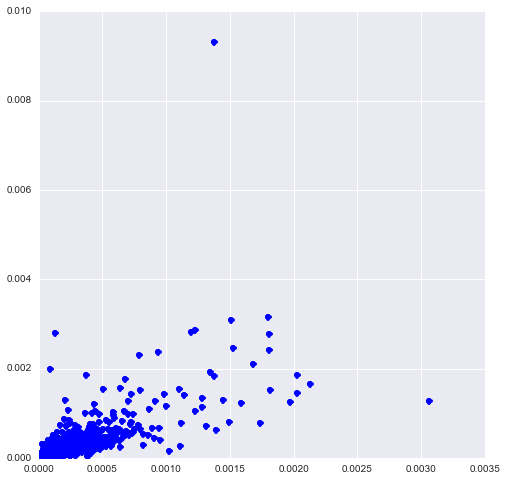

In [18]:
plt.figure(figsize=(8, 8))
plt.plot(rv_predict, rv_actual, 'bo');

Figure 14: Actual vols vs predicted vols.

### Superimpose actual and predicted vols

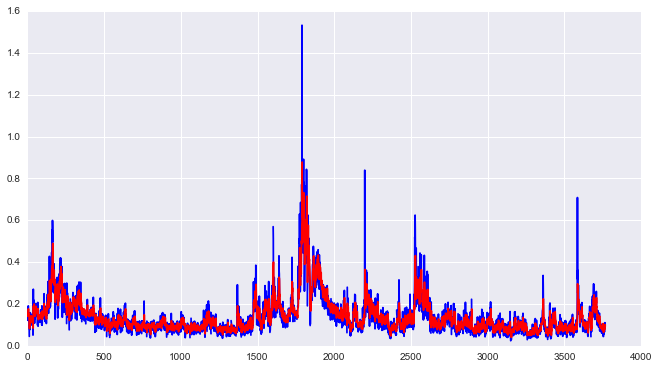

In [19]:
plt.figure(figsize=(11, 6))
vol_actual = np.sqrt(np.multiply(rv_actual,252))
vol_predict = np.sqrt(np.multiply(rv_predict,252))
plt.plot(vol_actual, "b")
plt.plot(vol_predict, "r");

Figure 15: Actual volatilities in blue; predicted vols in red.

### Forecasting the variance swap curve

Finally, we forecast the whole variance swap curve using the variance forecasting formula [(3)](#eq:vForecast).


In [20]:
def xi(date, tt, nu,h, tscale):  # dt=(u-t) is in units of years
    rvdata = pd.DataFrame(rv1['SPX2.rk'])
    return [ forecast_XTS(rvdata,h=h,date=date,nLags=500,delta=dt*tscale,nu=nu) for dt in tt]

nu = OxfordH["nu_est"][0]
h = OxfordH["h_est"][0]

def varSwapCurve(date, bigT, nSteps, nu, h, tscale, onFactor):
  # Make vector of fwd variances
  tt = [ float(i) * (bigT) / nSteps for i in range(nSteps+1)]
  delta_t = tt[1]
  xicurve = xi(date, tt, nu, h, tscale)
  xicurve_mid = (np.array(xicurve[0:nSteps]) + np.array(xicurve[1:nSteps+1])) / 2
  xicurve_int = np.cumsum(xicurve_mid) * delta_t
  varcurve1 = np.divide(xicurve_int, np.array(tt[1:]))
  varcurve = np.array([xicurve[0],]+list(varcurve1))
  varcurve = varcurve * onFactor * tscale #  onFactor is to compensate for overnight moves
  res = pd.DataFrame({"texp":np.array(tt), "vsQuote":np.sqrt(varcurve)})
  return(res)

In [21]:
def varSwapForecast(date,tau,nu,h,tscale,onFactor):
  vsc = varSwapCurve(date, bigT=2.5, nSteps=100, nu=nu, h=h,
                    tscale=tscale, onFactor=onFactor) # Creates the whole curve
  x = vsc['texp']
  y = vsc['vsQuote']
  res = stineman_interp(tau,x,y,None)

  return(res)

# Test the function

tau = (.25,.5,1,2)
date = dt.datetime(2008,9,8)
varSwapForecast(date,tau,nu=nu,h=h,tscale=252,onFactor=1)

array([ 0.21949454,  0.21398188,  0.2117466 ,  0.21262899])

### 'Constructing a time series of variance swap curves

For each of 2,658 days from Jan 27, 2003 to August 31, 2013:
 
  - We compute proxy variance swaps from closing prices of SPX options sourced from OptionMetrics (www.optionmetrics.com) via WRDS.
  
  
  - We form the forecasts $\eefm{v_u}{\mP}$ using [(3)](#eq:vForecast) with 500 lags of SPX RV data sourced from The Oxford-Man Institute of Quantitative Finance (http://realized.oxford-man.ox.ac.uk).
 
 

 
   - We note that the actual variance swap curve is a factor (of roughly 1.4) higher than the forecast, which we may attribute to a combination of overnight movements of the index and the price of volatility risk.
 
 
 - Forecasts must therefore be rescaled to obtain close-to-close realized variance forecasts.

### 3-month forecast vs actual variance swaps

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/02/vsfa3m.png" align = "left" width=900></h3> 

Figure 16: Actual (proxy) 3-month variance swap quotes in blue vs forecast in red (with no scaling factor).

### Ratio of actual to forecast

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/02/3mratio.png" align = "left" width=900></h3>

Figure 17: The ratio between 3-month actual variance swap quotes and 3-month forecasts.

### The Lehman weekend

 
  -  Empirically, it seems that the variance curve is a simple scaling factor times the forecast, but that this scaling factor is time-varying.
  
      - We can think of this factor as having two multiplicative components: the overnight factor, and the price of volatility risk.



  - Recall that as of the close on Friday September 12, 2008, it was widely believed that Lehman Brothers would be rescued over the weekend. By Monday morning, we knew that Lehman had failed. 

- In Figure 18, we see that variance swap curves just before and just after the collapse of Lehman are just rescaled versions of the RFSV forecast curves.

  

### We need variance swap estimates for 12-Sep-2008 and 15-Sep-2008

We proxy these by taking SVI fits for the two dates and computing the log-strips.

In [22]:
varSwaps12 =(
    0.2872021, 0.2754535, 0.2601864, 0.2544684, 0.2513854, 0.2515314,
    0.2508418, 0.2520099, 0.2502763, 0.2503309, 0.2580933, 0.2588361, 
    0.2565093)

texp12 = (
    0.01916496, 0.04654346, 0.09582478, 0.19164956, 0.26830938, 0.29842574,
    0.51745380, 0.54483231, 0.76659822, 0.79397673, 1.26488706, 1.76317591, 
    2.26146475)

varSwaps15 = (
    0.4410505, 0.3485560, 0.3083603, 0.2944378, 0.2756881, 0.2747838, 
    0.2682212, 0.2679770, 0.2668113, 0.2706713, 0.2729533, 0.2689598, 
    0.2733176)

texp15 = (
    0.01095140, 0.03832991, 0.08761123, 0.18343600, 0.26009582, 0.29021218, 
    0.50924025, 0.53661875, 0.75838467, 0.78576318, 1.25667351, 1.75496235, 
    2.25325120)

### Actual vs predicted over the Lehman weekend


In [23]:
nu = OxfordH['nu_est'][0]
h = OxfordH['h_est'][0]
date1 = dt.datetime(2008, 9, 12)
date2 = dt.datetime(2008, 9, 15)

# Variance curve fV model forecasts
tau1000 = [ float(i) * 2.5 / 1000. for i in range(1,1001)]
vs1 = varSwapForecast(date1, tau1000, nu=nu,h=h, tscale=252, onFactor=1.29)
vs2 = varSwapForecast(date2, tau1000, nu=nu,h=h, tscale=252, onFactor=1.29)

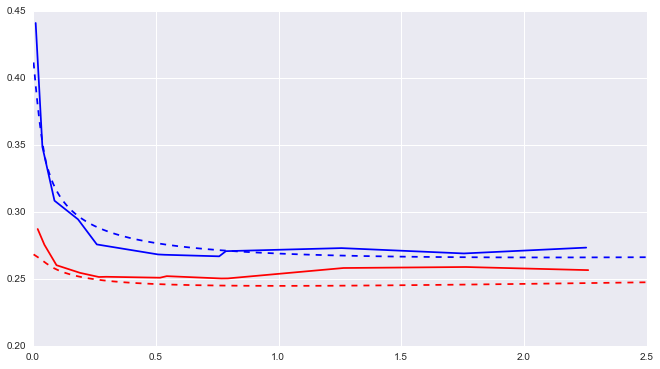

In [24]:
plt.figure(figsize=(11, 6))
plt.plot(texp12, varSwaps12, "r")
plt.plot(texp15, varSwaps15, "b")
plt.plot(tau1000, vs1, "r--")
plt.plot(tau1000, vs2, "b--");

Figure 18: SPX variance swap curves as of September 12, 2008 (red) and September 15, 2008 (blue). The dashed curves are RFSV model forecasts rescaled by the 3-month ratio ($1.29$) as of the Friday close.

### Remarks

We note that
 
  - The actual variance swaps curves are very close to the forecast curves, up to a scaling factor.
  
  
  - We are able to explain the change in the variance swap curve with only one extra observation: daily variance over the trading day on Monday 15-Sep-2008. 
 
 
 - The SPX options market appears to be backward-looking in a very sophisticated way.

 

### The Flash Crash

 
- The so-called Flash Crash of Thursday May 6, 2010 caused  intraday realized variance to be much higher than normal.   
  
  
- In Figure 19, we plot the actual variance swap curves as of the Wednesday and Friday market closes together with forecast curves rescaled by the 3-month ratio as of the close on Wednesday May 5 (which was $2.52$).  
  
  
- We see that the actual variance curve as of the close on Friday is consistent with a forecast from the time series of realized variance that *includes* the anomalous price action of Thursday May 6. 

### Variance swap estimates 

We again proxy variance swaps for 05-May-2010, 07-May-2010 and 10-May-2010 by taking SVI fits (see <span>[Gatheral and Jacquier]<sup id="cite_ref-GatheralJacquierSSVI" class="reference"><a href="#cite_note-GatheralJacquierSSVI"><span>[</span>4<span>]</span></a></sup> ) for the three dates and computing the log-strips.

In [25]:
varSwaps5 = (
    0.4250369, 0.2552473, 0.2492892, 0.2564899, 0.2612677, 0.2659618, 0.2705928, 0.2761203,
    0.2828139, 0.2841165, 0.2884955, 0.2895839, 0.2927817, 0.2992602, 0.3116500)

texp5 = (
    0.002737851, 0.043805613, 0.120465435, 0.150581793, 0.197125257, 0.292950034,
    0.369609856, 0.402464066, 0.618754278, 0.654346338, 0.867898700, 0.900752909,
    1.117043121, 1.615331964, 2.631074606)
 
varSwaps7 = (
    0.5469727, 0.4641713, 0.3963352, 0.3888213, 0.3762354, 0.3666858, 0.3615814, 0.3627013,
    0.3563324, 0.3573946, 0.3495730, 0.3533829, 0.3521515, 0.3506186, 0.3594066)

texp7 = (
    0.01642710, 0.03832991, 0.11498973, 0.14510609, 0.19164956, 0.28747433, 0.36413415,
    0.39698836, 0.61327858, 0.64887064, 0.86242300, 0.89527721, 1.11156742, 1.60985626,
    2.62559890)

varSwaps10 = (
    0.3718439, 0.3023223, 0.2844810, 0.2869835, 0.2886912, 0.2905637, 0.2957070, 0.2960737,
    0.3005086, 0.3031188, 0.3058492, 0.3065815, 0.3072041, 0.3122905, 0.3299425)

texp10 = (
    0.008213552, 0.030116359, 0.106776181, 0.136892539, 0.183436003, 0.279260780,
    0.355920602, 0.388774812, 0.605065024, 0.640657084, 0.854209446, 0.887063655,
    1.103353867, 1.601642710, 2.617385352)

In [26]:
date1 = dt.datetime(2010, 5, 5)
date2 = dt.datetime(2010, 5, 7)

vsf5 = varSwapCurve(date1, bigT=2.5, nSteps=100, nu=nu, h=h, tscale=252, onFactor=2.52)
vsf7 = varSwapCurve(date2, bigT=2.5, nSteps=100, nu=nu, h=h, tscale=252, onFactor=2.52)

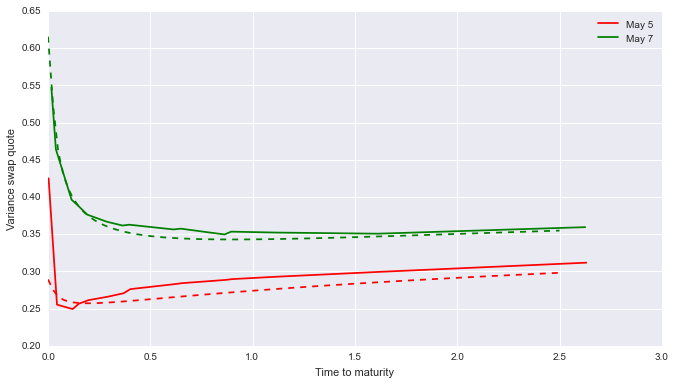

In [27]:
plt.figure(figsize=(11, 6))
plt.plot(texp5, varSwaps5, "r", label='May 5')
plt.plot(texp7, varSwaps7, "g", label='May 7')

plt.legend()
plt.xlabel("Time to maturity")
plt.ylabel("Variance swap quote")

plt.plot(vsf5['texp'], vsf5['vsQuote'], "r--")
plt.plot(vsf7['texp'], vsf7['vsQuote'], "g--");

Figure 19: SPX variance swap curves as of May 5, 2010 (red) and May 7, 2010 (green). The dashed curves are RFSV model forecasts rescaled by the 3-month ratio ($2.52$) as of the close on Wednesday May 5.  The curve as of the close on May 7 is consistent with the forecast **including** the crazy moves on May 6.


### The weekend after the Flash Crash

Now we plot forecast and actual variance swap curves as of the close on Friday May 7 and Monday May 10.

In [28]:
date1 = dt.datetime(2010,5,7)
date2 = dt.datetime(2010,5,10)

vsf7 = varSwapCurve(date1, bigT=2.5, nSteps=100, nu=nu, h=h, tscale=252, onFactor=2.52)
vsf10 = varSwapCurve(date2, bigT=2.5, nSteps=100, nu=nu, h=h, tscale=252, onFactor=2.52)

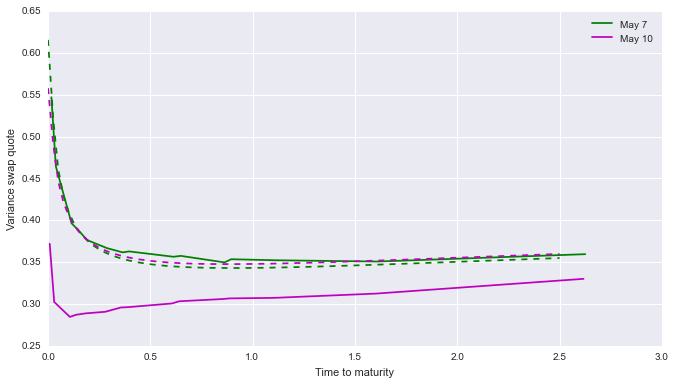

In [29]:
plt.figure(figsize=(11, 6))
plt.plot(texp7, varSwaps7, "g", label='May 7')
plt.plot(texp10, varSwaps10, "m", label='May 10')

plt.legend()
plt.xlabel("Time to maturity")
plt.ylabel("Variance swap quote")

plt.plot(vsf7['texp'], vsf7['vsQuote'], "g--")
plt.plot(vsf10['texp'], vsf10['vsQuote'], "m--");

Figure 20: The May 10 actual curve is  inconsistent with a forecast that includes the Flash Crash.  


Now let's see what happens if we exclude the Flash Crash from the time series used to generate the variance curve forecast. 

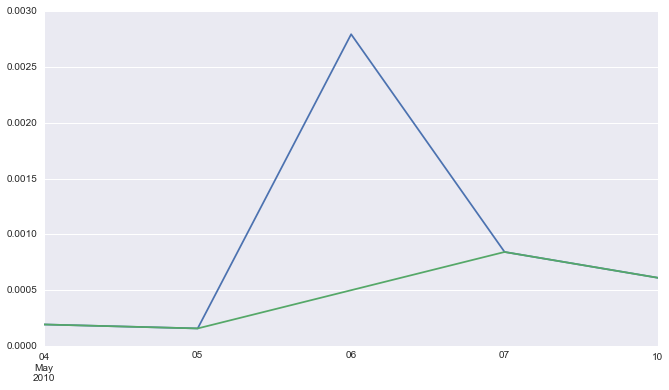

In [30]:
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)
rvdata_p = rvdata.drop((dt.datetime(2010, 5, 6)), axis=0)
rvdata.loc["2010-05-04":"2010-05-10"].plot(ax=ax, legend=False)
rvdata_p.loc["2010-05-04":"2010-05-10"].plot(ax=ax, legend=False);

Figure 21: `rvdata_p` has the May 6 realized variance datapoint eliminated (green line).  Notice the crazy realized variance estimate for May 6!

We need a new variance curve forecast function that uses the new time series.

In [31]:
def xip(date, tt, nu,h, tscale):  # dt=(u-t) is in units of years
    rvdata = pd.DataFrame(rv1['SPX2.rk'])
    rvdata_p = rvdata.drop((dt.datetime(2010, 5, 6)), axis=0)
    return [ forecast_XTS(rvdata_p, h=h, date=date,nLags=500,
                          delta=delta_t * tscale, nu=nu) for delta_t in tt]

nu = OxfordH["nu_est"][0]
h = OxfordH["h_est"][0]

def varSwapCurve_p(date, bigT, nSteps, nu, h, tscale, onFactor):
  # Make vector of fwd variances
  tt = [ float(i) * (bigT) / nSteps for i in range(nSteps+1)]
  delta_t = tt[1]
  xicurve = xip(date, tt, nu, h, tscale)
  xicurve_mid = (np.array(xicurve[0:nSteps]) + np.array(xicurve[1:nSteps + 1])) / 2
  xicurve_int = np.cumsum(xicurve_mid) * delta_t
  varcurve1 = np.divide(xicurve_int, np.array(tt[1:]))
  varcurve = np.array([xicurve[0],]+list(varcurve1))
  varcurve = varcurve * onFactor * tscale #  onFactor is to compensate for overnight moves
  res = pd.DataFrame({"texp":np.array(tt), "vsQuote":np.sqrt(varcurve)})
  return(res)

def varSwapForecast_p(date, tau, nu, h, tscale, onFactor):
  vsc = varSwapCurve_p(date, bigT=2.5, nSteps=100, nu=nu, h=h,
                    tscale=tscale, onFactor=onFactor) # Creates the whole curve
  x = vsc['texp']
  y = vsc['vsQuote']
  res = stineman_interp(tau, x, y, None)

  return(res)

# Test the function

tau = (.25, .5 ,1, 2)
date = dt.datetime(2010, 5, 10)
varSwapForecast_p(date, tau, nu=nu, h=h, tscale=252, onFactor=1. / (1 - .35))

array([ 0.26077084,  0.25255902,  0.25299844,  0.26116175])

Finally, we compare our new forecast curves with the actuals.

In [32]:
date1 = dt.datetime(2010, 5, 7)
date2 = dt.datetime(2010, 5, 10)

vsf7 = varSwapCurve(date1, bigT=2.5, nSteps=100, nu=nu, h=h, tscale=252, onFactor=2.52)
vsf10p = varSwapCurve_p(date2, bigT=2.5, nSteps=100, nu=nu, h=h, tscale=252, onFactor=2.52)

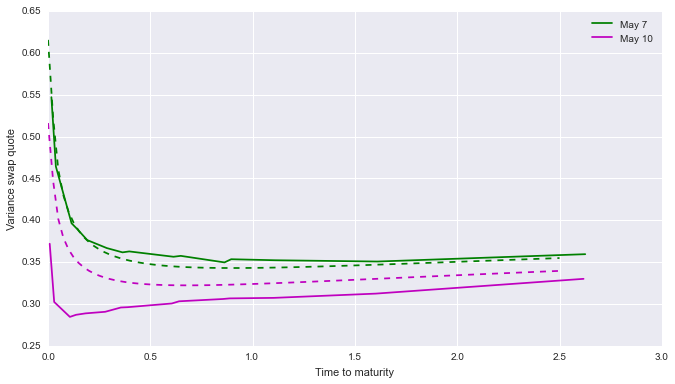

In [33]:
plt.figure(figsize=(11, 6))
plt.plot(texp7, varSwaps7, "g", label='May 7')
plt.plot(texp10, varSwaps10, "m", label='May 10')

plt.legend()
plt.xlabel("Time to maturity")
plt.ylabel("Variance swap quote")

plt.plot(vsf7['texp'], vsf7['vsQuote'], "g--")
plt.plot(vsf10p['texp'], vsf10p['vsQuote'], "m--");

Figure 22: The May 10 actual curve is consistent with a forecast that excludes the Flash Crash.

###  Resetting of expectations over the weekend  
  
  -  In Figures 20 and 22, we see that the actual variance swap curve on Monday, May 10  is consistent with a  forecast that excludes the  Flash Crash.
 
 
  - Volatility traders realized that the Flash Crash should not influence future realized variance projections.

### Summary

 
  - We uncovered a remarkable monofractal scaling relationship in historical volatility.
 
      - A corollary is that volatility is not a long memory process, as widely believed.
  
  
  - This leads to a natural non-Markovian stochastic volatility model under $\mP$.
  
  
  - The simplest specification of $\frac{d\mQ}{d\mP}$ gives a non-Markovian generalization of the Bergomi model.
 

  
  - The history of the Brownian motion $\lbrace W_s, s<t\rbrace $ required for pricing is encoded in the forward variance curve, which is observed in the market.
  

  - This model fits the observed volatility surface surprisingly well with very few parameters.
 
 
 
- For perhaps the first time, we have a simple consistent model of historical and implied volatility.

 

## References  

<br />

<div class="reflist" style="list-style-type: decimal;">

<ol>

<li id="cite_note-ABDE"><span class="mw-cite-backlink"><b><a href="#cite_ref-ABDE">^</a></b></span>
Torben G Andersen, Tim Bollerslev, Francis X Diebold, and Heiko Ebens, The distribution of realized stock return volatility, *Journal of Financial Economics* **61**(1) 43-76 (2001).
</li>

<li id="cite_note-BayerFriz"><span class="mw-cite-backlink"><b><a href="#cite_ref-BayerFriz">^</a></b></span> 
Christian Bayer, Peter Friz and Jim Gatheral, Pricing under rough volatility, *Quantitative Finance* forthcoming, available at http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554754, (2015).
</li>
 
<li id="cite_note-BacryMuzy"><span class="mw-cite-backlink"><b><a href="#cite_ref-BacryMuzy">^</a></b></span>
Emmanuel Bacry and Jean-François Muzy, Log-infinitely divisible multifractal processes, 
*Communications in Mathematical Physics* **236**(3) 449-475 (2003).</li>
 

 <li id="cite_note-GatheralJacquierSSVI"><span class="mw-cite-backlink"><b><a href="#cite_ref-GatheralJacquierSSVI">^</a></b></span>  Jim Gatheral and Antoine Jacquier, Arbitrage-free SVI volatility
surfaces, <span>*Quantitative Finance*</span> <span>**14**</span>(1) 59-71 (2014).</li>

<li id="cite_note-GJR"><span class="mw-cite-backlink"><b><a href="#cite_ref-GJR">^</a></b></span> Jim Gatheral, Thibault Jaisson and Mathieu Rosenbaum, Volatility is rough, available at http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2509457, (2014).</li>

<li id="cite_note-GO"><span class="mw-cite-backlink"><b><a href="#cite_ref-GO">^</a></b></span> Jim Gatheral and Roel Oomen, Zero-intelligence realized variance estimation, *Finance and Stochastics* **14**(2) 249-283 (2010).</li> 
 
<li id="cite_note-NuzmanPoor"><span class="mw-cite-backlink"><b><a href="#cite_ref-NuzmanPoor">^</a></b></span> Carl J. Nuzman and H. Vincent Poor, Linear estimation of self-similar processes via Lamperti’s transformation, *Journal of Applied Probability* **37**(2) 429-452 (2000).</li>
 
 

</ol>
  


 